# Trust Region Policy Optimization implementation

## Misc derivations

### Backtracking Line Search step size

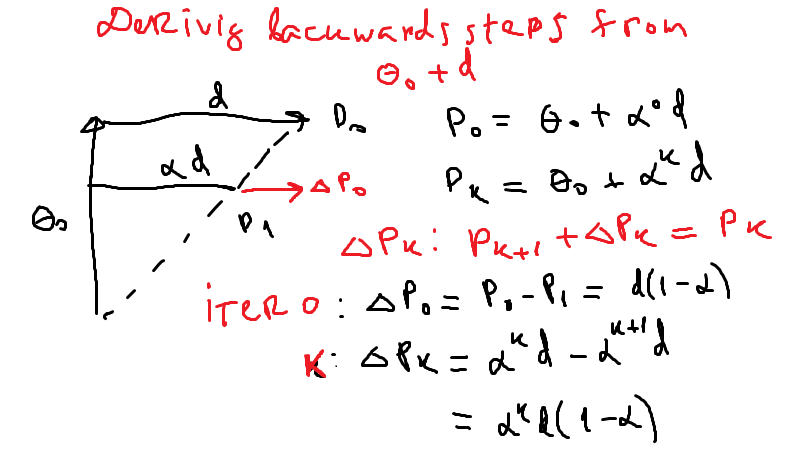

$$\sum_{k=0}^\infty \alpha^k (1-\alpha) = (1-\alpha) \sum_{k=0}^\infty \alpha^k \overset{\text{geom series}}{=} (1-\alpha) \frac{1}{1-\alpha} = 1$$

### Generalized Advantage Estimation (GAE)

TD error-like:
*   1-step:
    $$\delta_t^V = r_t + \gamma V(s_{t+1}) - V(s_t)$$



$$\hat A_t^{(1)} = \delta_t^V = - V(s_t) + r_t + \gamma V(s_{t+1}) $$
$$\hat A_t^{(2)} = \delta_t^V+ \gamma \delta_{t+1}^V = - V(s_t) + \gamma V(s_{t+1}) $$
$$ =  \left[- V(s_t)  + r_t + \gamma V(s_{t+1})\right] + \gamma \left[r_{t+1} + \gamma V(s_{t+2}) -  V(s_{t+1}) \right]$$
$$ =  - V(s_t)  + r_t + \cancel{\gamma V(s_{t+1})} + \gamma r_{t+1} + \gamma^2 V(s_{t+2}) -  \cancel{\gamma V(s_{t+1})} $$
$$\hat A_t^{(2)} = - V(s_t)  + r_t  + \gamma r_{t+1} + \gamma^2 V(s_{t+2})$$
$$\hat A_t^{(k)} =\sum_{l=0}^k \gamma^l  \delta_{t+l}^V= - V(s_t)  + r_t + \dots + \gamma^{k-1} r_{t+k-1} + \gamma^k V(s_{t+k})$$

for infinite steps converges to empirical (MC) reward - baseline:
$$\hat A_t^{(\infty)} =\sum_{l=0}^\infty \gamma^l  \delta_{t+l}^V= - V(s_t)  + \sum_{l=0}^\infty \gamma^l r_{l}$$

### GAE($\gamma, \lambda$)

is exponentially weighted of estimators $\hat A_{t}^{k}$:
$$\hat A_{t}^{k} = (1-\lambda)(\hat A_{t}^{1}+ \lambda \hat A_{t}^{2} + \dots)$$

## Import

In [2]:
# had to install pip install ufal.pybox2d (for Windows) for Box[] environments !!!
EPS     = 1e-8
import matplotlib.pyplot as plt
import os, torch, gym
from tqdm import tqdm
from typing import List
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn as nn
from torch.distributions.categorical import Categorical # https://pytorch.org/docs/stable/distributions.html#categorical
from torch.distributions.normal import Normal           # https://pytorch.org/docs/stable/distributions.html#normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.nn.utils import parameters_to_vector         # https://pytorch.org/docs/stable/generated/torch.nn.utils.parameters_to_vector.html
from torch.optim import Adam
from IPython.display import clear_output
clear_output()

def update_model_params(model, flat_params):
    offset = 0
    for p in model.parameters():
        numel = p.numel()
        #p.data.copy_(flat_params[offset:offset+numel].view_as(p))
        p.data += flat_params[offset:offset+numel].view_as(p)
        offset += numel

## Env class definition

In [3]:
class TRPO_env():
    """this 'wrapper' modifies env control
        automatically adds non terminal states, actions and reward into a buffer
        tracks episode rewards and calculates cumulative future rewards
        """
    def __init__(self, id, device = 'cpu', lam = 0.95, gamma = 0.99, **kwargs) -> None:
        self.env = gym.make(id, **kwargs)
        self.env_iters          = 0
        self.device             = device
        self.dtype              = torch.float32
        self.tensor_params      = {'dtype': self.dtype, 'device': device}
        self.tensor_params2     = {'dtype': self.dtype, 'device': 'cpu'}
        self.chunks             = []
        self.lam, self.gamma    = lam, gamma
        
    def gpu_float_tensor(self, x):
        return torch.as_tensor(x, device=self.device, dtype=self.dtype)
    
    def init_batches(self, len_max, state_dim, action_dim):
        self.batch_states_cpu  = torch.zeros(size=(len_max, state_dim) , **self.tensor_params2)
        self.batch_actions_cpu  = torch.zeros(size=(len_max, action_dim), **self.tensor_params2)
        self.batch_rewards_cpu  = torch.zeros(size=(len_max, )          , **self.tensor_params2)

    def clear_batches(self):
        self.batch_states_cpu   = 0*self.batch_states_cpu   
        self.batch_actions_cpu  = 0*self.batch_actions_cpu 
        self.batch_rewards_cpu  = 0*self.batch_rewards_cpu 
        self.chunks             = []

    def reset_episode_batch(self, idx_from):
        # self.chunks is simply not called
        self.batch_states_cpu [idx_from:] *= 0 
        self.batch_actions_cpu[idx_from:] *= 0 
        self.batch_rewards_cpu[idx_from:] *= 0
                 
    def reset(self, idx):
        """ Resets env and remembers new state"""
        state = self.env.reset()[0]
        state = self.gpu_float_tensor(state)
        self.batch_states_cpu[idx] = state
        return state
    
    def step(self, action, idx):
        """ On time step remember state, action and reward received."""
        state, reward, done         = self.env.step(action)[:3]
        state   = torch.as_tensor(state, **self.tensor_params2) 
        action  = torch.as_tensor(action,**self.tensor_params2) 
        self.batch_rewards_cpu[idx]   = reward
        self.batch_actions_cpu[idx]   = action
        self.batch_states_cpu [idx+1] = state       # reset added time=0 state
        return self.gpu_float_tensor(state), done   # need NN input on gpu
    
    @torch.no_grad()
    def play_batch_terminal_only(self, policy, eps_per_batch, max_ep_len = float('inf'), report_period = 50, tqdm_iter_params = None):
        if tqdm_iter_params is not None: tqdm_iter, tqdm_params = tqdm_iter_params
        def tqdm_report(x,y): 
            if tqdm_iter_params is not None: tqdm_iter.set_postfix(**tqdm_params, batch_size = x, epoch = y)
        self.clear_batches()
        total_successful_steps = 0
        for epoch in range(eps_per_batch):
            got_successful_termination = False
            while not got_successful_termination:
                tqdm_report(total_successful_steps,epoch)
                time = 0
                obs  = self.reset(total_successful_steps)
                while True:
                    total_steps_epoch = total_successful_steps + time
                    if time % report_period == 0: tqdm_report(total_steps_epoch,epoch)
                    action = policy.get_action(obs) 
                    obs, episode_finished = self.step(action,total_steps_epoch)
                    if time + 1 >= max_ep_len and not episode_finished:
                        self.reset_episode_batch(total_successful_steps) 
                        break
                    if episode_finished:                  
                        self.env_iters  += 1
                        self.chunks.append(time+1)  # ep length
                        got_successful_termination = True
                        total_successful_steps = total_successful_steps + time + 1 # offset +1 for next episode
                        break
                       
                    time += 1
        # ====== Trim unused entries. Terminal state should be discarded. =========       
        self.batch_states     = self.batch_states_cpu [:total_successful_steps].to(self.device)
        self.batch_actions    = self.batch_actions_cpu[:total_successful_steps].to(self.device)
        self.batch_rewards    = self.batch_rewards_cpu[:total_successful_steps].to(self.device)
        return 1

    # play_batch() is not used. Its not updated for reserved memory and has flawed goal logic.
    @torch.no_grad()
    def play_batch(self, policy, value, eps_per_batch, max_batch_size, max_ep_len = float('inf'), trunk_is_success = False,  tqdm_iter_params = None):
        """episode-per-batch-centric point of view. At early learning i want to finish set number of episodes.
            - max_batch_size is a memory buffer size. If its full stop playing episodes (leave_epoch_loop flag stops iterations).
            There are environments where, in order to learn, its necessary to terminate successfully. (we will return to this)
            - max_ep_len is manual ep truncation (replaces OG). early-terminated reward is bootstrapped with state value
            - trunk_is_success flag controls if we accept results that did not terminate correctly (no final reward)
            Sometimes first episode will fill whole buffer. If we want true termination (trunk_is_success = 0 (EDIT:correct?))
            then i will discard current data and restart epoch 1. Once i get first successful termination, i stop restarting."""
            
        if tqdm_iter_params is not None: tqdm_iter, tqdm_params = tqdm_iter_params
        max_ep_len = min(max_batch_size,max_ep_len) # if batch is smaller then max ep length
        leave_epoch_loop   = False  
        got_successful_termination   = False  # is True on first successfully terminated trajectory
        batch_L            = 0
        while not got_successful_termination:
            self.clear_batches()
            policy.clear_batches()
            for i in range(eps_per_batch):
                time = 0
                obs  = self.reset(**policy.tensor_params)
                while True:
                    if time % 50 == 0:
                        batch_L = len(self.batch_states)
                        if tqdm_iter_params is not None: tqdm_iter.set_postfix(**tqdm_params, batch_size = batch_L)
                    action = policy.get_action(obs) 
                    obs, episode_finished = self.step(action, **policy.tensor_params)
                    batch_full = len(self.batch_states) >= max_batch_size
                    episode_finished = time >= max_ep_len-1 if trunk_is_success else episode_finished
                    early_termination =  time >= max_ep_len-1 or batch_full
                    if episode_finished or early_termination:                   # if finished or big episode or batch full
                        if episode_finished: got_successful_termination = True  # cancel outer loop
                        else: self.batch_rewards[-1] += self.gamma * value(obs) # bootstrap early termination. TD1 =
                                                                                # current reward + gamma * future reward
                        if batch_full:                                          # stop collecting data (in outer loop iter)
                            leave_epoch_loop = True
                            if not got_successful_termination: break            # full batch without any finished runs. dont add iter
                                                                           
                        self.env_iters  += 1
                        self.chunks.append(time+1)
                        break
                    else:   # next state is non-terminal. add to batch
                        self.batch_states.append(obs)
                        time += 1
                    
                if leave_epoch_loop: break

        self.batch_states     = torch.stack(self.batch_states ).to(**policy.tensor_params)
        self.batch_actions    = torch.stack(self.batch_actions).to(**policy.tensor_params)
        self.batch_rewards    = torch.tensor(self.batch_rewards, **policy.tensor_params)
        #policy.finalize_batch()
        return 1
    
    def rewards_2_go(self, use_gamma = False):
        self.r2g = torch.zeros_like(self.batch_rewards)
        chunks_r = torch.split(self.batch_rewards,self.chunks)
        z= 0
        for rews,c in zip(chunks_r, self.chunks):
            if use_gamma: 
                for t in range(len(rews)):
                    self.r2g[z:z+c][t] = torch.sum(rews[t:]*self.gamma**torch.arange(len(rews[t:]), device = device, dtype = torch.float32))
            else:
                self.r2g[z:z+c] = torch.flip(torch.cumsum(torch.flip(rews,(0,)),0),(0,))
            z += c
        return self.r2g
    
    @torch.no_grad()
    def advantages_GAE(self, value,**kwargs):
        chunks_Vs = torch.split(value(self.batch_states).reshape(-1), self.chunks)
        chunks_r  = torch.split(self.batch_rewards,self.chunks)
        advantages = []
        for Rw, Vs in zip(chunks_r, chunks_Vs):
            Vs = torch.cat((Vs, torch.tensor([0], **kwargs)))
            deltas = Rw + self.gamma * Vs[1:] - Vs[:-1]
            adv = torch.zeros_like(Rw, **kwargs)
            gae = 0
            for t in reversed(range(len(Rw))):
                gae = deltas[t] + self.gamma * self.lam * gae
                adv[t] = gae
            advantages.append(adv)
        return torch.cat(advantages)

## Policy definition (discrete/continuous actions)

In [4]:
class torch_MLP(nn.Module):
    def __init__(self, inp_size: int, out_size: int, hidden_sizes: List[int],
                 activation = nn.Tanh, activation_out = nn.Identity, 
                 optimizer = None, lr: float = 1e-2) -> None:
        super().__init__()
        self.dtype          = torch.float32
        self.tensor_params  = {'dtype': self.dtype, 'device': device}
        self.act            = activation
        self.act_out        = activation_out
        self.dense          = self.seq([inp_size] + hidden_sizes + [out_size]).to(device)
        self.optimizer = None if optimizer is None else optimizer(self.parameters(), lr=lr)

    def seq(self, layers_size):
        layers      = []
        for i,j in zip(layers_size[:-1],layers_size[1:]):
            layers  += [nn.Linear(i,j, **self.tensor_params), self.act()]
        layers[-1]  = self.act_out()
        return nn.Sequential(*layers)
    
    def forward(self, obs):
        return self.dense(obs)

class torch_MLP_Normal(torch_MLP):
    """ inherits dense layer block, adds extra parameters"""
    def __init__(self, inp_size: int, out_size: int, hidden_sizes:List[int],
                 activation = nn.Tanh, activation_out = nn.Identity, optimizer = None, lr: float = 1e-2) -> None:
        super().__init__(inp_size, out_size, hidden_sizes, activation, activation_out, optimizer, lr)

        self.log_std = torch.nn.Parameter(0.5*torch.ones(size=(out_size,),**self.tensor_params))

class TRPO_Proto_Policy():
    """all TRPO policies will have: 1) NN, 2) gradient, 3) log_p_old"""
    def __init__(self, obs_dim: int, num_actions:int, hidden_sizes:List[int], model = torch_MLP, activation=nn.Tanh, activation_out=nn.Identity, optimizer = None, lr: float=0.01) -> None:
        self.mlp = model(obs_dim, num_actions, hidden_sizes, activation, activation_out, optimizer, lr)
        self.tensor_params = self.mlp.tensor_params
        self.D_KL           = torch.tensor(0.0, **self.tensor_params)
        self.U_rew          = torch.tensor(0.0, **self.tensor_params)
        self.U_rew_old      = torch.tensor(0.0, **self.tensor_params)
        self.MLP_num_prms   = sum(p.numel() for p in self.mlp.parameters())
        self.grad           = torch.zeros(size = (self.MLP_num_prms ,), **self.tensor_params)
        self.logP_old= []
        self.logP    = []
        self.logP_grads     = []

    def get_policy(self, observation): 
        """Returns a distribution of probabilities for a particular observation/-s."""
        pass

    def get_action(self, observation):
        """Samples action from distribution. Remembers log-prob of given action."""
        distribution    = self.get_policy(observation)
        action          = distribution.sample()
        return action
    
    def batch_calc_logPs(self, observations, actions):
        """ Generate log-probs using current version of policy"""
        distribution    = self.get_policy(observations)
        self.logP       = distribution.log_prob(actions).flatten()  # shape: (batch,)
        return distribution

    def prep_old_policy(self):
        self.logP_old = self.logP.clone().detach()

    def calc_KL_div(self):
        """Calculate KL divergence. Implementation depends on action space type"""
        pass

    def calc_flat_grad(self, f, create_graph = False, retain_graph = True):
        """ Calculate gradient of scalar function with respect to network parameters.
            create_graph=True for higher order derivatives, retain_graph = False will 
            wipe intermediate values from graph. Its a big no-no"""
        # Retain by default, and by default no higher order grads.
        g = torch.autograd.grad(f, self.mlp.parameters(), create_graph = create_graph, retain_graph = retain_graph)
        return parameters_to_vector(g)
    
    def calc_NPG_logP_grads(self):
        """ Calculates gradient for each 
            log-probability of action a taken in state s -> grad(log(a_t|s_t))
            for all t in a batch. These are needed for NPG grad and FIM"""
        self.logP_grads = torch.zeros(size = (len(self.logP),self.MLP_num_prms), **self.tensor_params)
        for i in range(len(self.logP)):
            self.logP_grads[i] = self.calc_flat_grad(self.logP[i])
        return self.logP_grads 
    
    def calc_NPG_grad(self, advantages):
        """Calculates NPG type gradient of objective function"""
        grad = self.logP_grads*advantages.reshape(-1,1)
        grad = grad.mean(dim=0)
        return grad
    
    def calc_surrogate_reward(self, advantages):
        """Calculate TRPO type objective function /w importance sampling"""
        loss = torch.exp(self.logP - self.logP_old)*(advantages.flatten())
        loss = loss.mean(dim = 0)
        return loss
    
    def calf_FIM(self, regularization = 0.001):
        """ Calculates Fisher's Information Matrix (FIM) via gradients of logP_old.
            Relevant only for old policy to get curvature of parameter space"""
        FIM = self.logP_grads.unsqueeze(-1) * self.logP_grads.unsqueeze(-2) # batched outer product via broadcasting (T,N,1) * (T,1,N)
        FIM = FIM.mean(dim=0) 
        FIM += regularization * torch.eye(self.MLP_num_prms, device=device) 
        return FIM  
    
    def calc_Hessian(self, regularization = 0.001):
        """"Calculate Hessian as the Jacobian of a gradient.
            1) Create gradient of KL divergence (with graph enabled);
            2) Go through each entry and calculate gradient;
            3) drop from graph since we need to know direction once."""                     
        flat_KL_grad = self.calc_flat_grad(self.D_KL, create_graph=True)
        H = torch.zeros(size = (self.MLP_num_prms,)*2, **self.tensor_params)
        for i in range(len(flat_KL_grad)):
            H[i] = self.calc_flat_grad(flat_KL_grad[i])
        H.requires_grad_(False)
        H += regularization * torch.eye(self.MLP_num_prms, **self.tensor_params)
        return H


class Policy_Discrete(TRPO_Proto_Policy):
    """"""
    def __init__(self, obs_dim: int, num_actions: int, hidden_sizes: List[int], model=torch_MLP, activation=nn.Tanh, activation_out=nn.Identity, optimizer=None, lr: float = 0.01) -> None:
        super().__init__(obs_dim, num_actions, hidden_sizes, model, activation, activation_out, optimizer, lr)
        """For discrete case need (and can access) to probability distributions over actions for any state"""
        self.logP_distr       = []  #batch length x num actions
        self.logP_distr_old   = []  

    def get_policy(self, observation): 
        """Distribution for discrete actions"""
        return Categorical(logits=self.mlp(observation))
    
    def get_action(self, observation):
        """Added saving of log P(.,s) for D_KL"""
        return super().get_action(observation).item()
   
    def batch_calc_logPs(self, observations, actions):
        """ For discrete case calculate:
            -   for importance sampling: (log) probabilities for chosen action for each state in trajectory
            -   for KL divergence prob distr over actions (for all visited states St at time t)
                distr(St) = log [P(a1,St), P(a2,St), ...]"""
        distribution = super().batch_calc_logPs(observations, actions.flatten())
        self.logP_distr   = torch.log(distribution.probs)
        
    def prep_old_policy(self):
        """Create old version of policy without gradient enabled"""
        super().prep_old_policy()
        self.logP_distr_old   = self.logP_distr.clone().detach()

    def calc_KL_div(self):
        """ Defined KL divergence specifically for discrete actions. 
            NOTE: logP_all uses grad, logP_all_old does not."""
        temp = torch.exp(self.logP_distr_old)*(self.logP_distr_old- self.logP_distr)
        return temp.sum(dim=-1).mean()

class Policy_continuous(TRPO_Proto_Policy):
    """ NN produces mean value vector parameter for Gaussian distribution, from which actions are sampled.
        state maps to mean vector, Gaussian distribution, additional trainable parameters are stdev 
        for all actions.
        for KL divergence we collect mean and stdev for each visited state."""
    def __init__(self, obs_dim: int, num_actions: int, hidden_sizes: List[int], model=torch_MLP_Normal, activation=nn.Tanh, activation_out=nn.Identity, optimizer=None, lr: float = 0.01) -> None:
        super().__init__(obs_dim, num_actions, hidden_sizes, model, activation, activation_out, optimizer, lr)
        self.mus , self.mus_old = [], []
        self.log_std_old        = torch.zeros(size=(num_actions,), **self.tensor_params)

    def calc_log_prob(self, action, mu, log_std):
        """NOT USED: can be calculated using Normal(mu,std).log_prob(action)"""
        return -0.5*(torch.log(2*torch.tensor(torch.pi))+ 2*log_std + ((action - mu)/(torch.exp(log_std)+ EPS))**2)
    
    def get_policy(self, observation):
        """Get Multivariate Normal distribution"""
        mus  = self.mlp(observation)
        stds = self.mlp.log_std.exp()
        return MultivariateNormal(mus, torch.diag(stds))

    def get_action(self, observation):
        """Sample from gaussian, remember parameter"""
        return super().get_action(observation).cpu().numpy() # array, not int
    
    def batch_calc_logPs(self, observations, actions):
        """ For contious case calculate:
            -   for importance sampling: (log) probabilities for chosen action for each state in trajectory
            -   for KL divergence parameters of multivariate gaussian (for all visited states St at time t)
                [mu(S0), mu(S1), ...]; state does not determine stdev."""
        distribution = super().batch_calc_logPs(observations, actions)
        self.mus = distribution.mean

    def prep_old_policy(self):
        """Create old version of policy without gradient enabled"""
        super().prep_old_policy()
        self.mus_old        = self.mus.clone().detach()
        self.log_std_old    = self.mlp.log_std.clone().detach()

    def KL_div(self, mu_old, log_std_old, mu, log_std):
        var_old, var = torch.exp(2*log_std_old), torch.exp(2*log_std)
        dkl = 0.5*(((mu_old - mu)**2 + var_old)/var - 1) + log_std - log_std_old
        return dkl.sum(dim = -1).mean()
    
    def calc_KL_div(self):
        mu_old, log_std_old = self.mus_old  , self.log_std_old
        mu, log_std         = self.mus      , self.mlp.log_std
        return self.KL_div(mu_old, log_std_old, mu, log_std)

## Misc class definitions

In [5]:
class value(torch_MLP):
    def __init__(self, inp_size, out_size, hidden_sizes, activation=nn.ReLU, activation_out=nn.Identity, optimizer= Adam, lr=0.01) -> None:
        super().__init__(inp_size, out_size, hidden_sizes, activation, activation_out, optimizer, lr)
        self.loss = nn.MSELoss()
    
    def train(self, observations, rewards, n_iters = 50):
        for _ in range(n_iters):
            self.optimizer.zero_grad()
            x = self(observations)
            y = rewards.reshape(x.shape)
            output = self.loss(x,y)
            output.backward()
            self.optimizer.step()
            
def conjugate_gradient_hess(Av, b, x0=None, max_iters = None, tol = 1e-10):
    x = torch.zeros_like(b) if x0 is None else x0  #init guess
    r           = b - Av(x)    # residual
    d           = r.clone()  # direction
    rr          = torch.dot(r,r)
    num_iters   = len(b) if max_iters is None else max_iters
    for _ in range(num_iters):
        Ad          = Av(d)
        step_size   = rr/ (d @ Ad)
        x           += step_size * d
        r           -= step_size * Ad
        rr_new      = torch.dot(r,r)
        if rr_new < tol: break
        d           = r + (rr_new/rr)*d
        rr          = rr_new.clone()
    return x.detach()

## Continuous environments

In [6]:
torch.cuda.empty_cache() 
env_params = {'id':'MountainCarContinuous-v0'}      # trunk at 999 steps. https://www.gymlibrary.dev/environments/classic_control/mountain_car_continuous
#env_params = {'id':'Pendulum-v1','g':9.81}          # trunk at 200 stepshttps://www.gymlibrary.dev/environments/classic_control/pendulum/
#env_params = {'id':"BipedalWalker-v3"}              # (bad) trunk 1000 https://www.gymlibrary.dev/environments/mujoco/inverted_pendulum/
#env_params = {'id':"LunarLander-v2", 'continuous':True} # https://www.gymlibrary.dev/environments/box2d/lunar_lander/
env_CP = TRPO_env(**env_params,  device = device)
num_obs  = env_CP.env.observation_space.shape[0]
num_acts = env_CP.env.action_space.shape[0]
dim_acts = num_acts
env_CP_policy   = Policy_continuous(num_obs, num_acts, [32])
env_CP_value    = value(num_obs, 1 , [32], lr = 0.01)
progress     = []
progress_std = []
step_lengths = []
print(env_CP.env.action_space);print(env_CP.env.observation_space)

Box(-1.0, 1.0, (1,), float32)
Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


## Discrete environments

In [7]:
torch.cuda.empty_cache() 
# reward_cap = 300
#env_params = {'id':"CartPole-v1"}
#env_params = {'id':"MountainCar-v0"}    # (bad, hard to terminate)
#env_params = {'id':"LunarLander-v2", 'continuous':False}  # https://www.gymlibrary.dev/environments/box2d/lunar_lander/
env_params = {'id':"Acrobot-v1"} # (bad, hard to terminate) https://www.gymlibrary.dev/environments/classic_control/acrobot/

env_CP      = TRPO_env(**env_params, device=device)
num_obs     = env_CP.env.observation_space.shape[0]
num_acts    = env_CP.env.action_space.n
dim_acts    = 1
env_CP_policy   = Policy_Discrete(num_obs, num_acts, [32])
env_CP_value    = value(num_obs, 1, [32], lr = 0.01)
progress    = []
progress_std= []
step_lengths = []

## Agent training loop

In [8]:
if 1 == 1:
    print(env_params)
    case_name       = "_".join([f'{i}-{j}' for i,j in env_params.items()])
    eps_per_batch   = 3
    max_ep_len      = 15000
    tq_iter         = tqdm(range(30))
    delta           = 1e-2
    use_gamma       = True
    backtrack_coeff = 0.8
    backtrack_iters = 10
    damping         = 0.1
    EPS             = 1e-8
    use_FIM         = False
    use_CG          = True
    CG_Iters        = 20
    tq_prms         = { '1.avg_cum_reward_mean'  :0, '2.avg_cum_reward_std'   :0, 
                        '3. step_len'            :0, 'evals'                  :env_CP.env_iters}
    step_len        = lambda k: backtrack_coeff**k*(1-backtrack_coeff) # see derivation image
    inverse_regularization  = 0.001
for _ in tq_iter: 
    env_CP.init_batches(eps_per_batch*max_ep_len, num_obs, dim_acts)
    # ========= Gather successful episodes =============
    env_CP.play_batch_terminal_only(env_CP_policy, eps_per_batch, max_ep_len, report_period = 50, tqdm_iter_params = (tq_iter,tq_prms))
    # ========= Calculate cumulative rewards =============
    advantages = env_CP.advantages_GAE(env_CP_value, **env_CP_policy.tensor_params)
    rewards_to_go = env_CP.rewards_2_go(use_gamma)
    # ========= Fit Value function =============
    env_CP_value.train(env_CP.batch_states, rewards_to_go, n_iters=1000) # fit state value function
    # ========= Prepare 'new' and old policy =============
    env_CP_policy.batch_calc_logPs(env_CP.batch_states, env_CP.batch_actions)
    env_CP_policy.prep_old_policy()
    # ====== First iter grad reduces to NPG grad ==========
    env_CP_policy.calc_NPG_logP_grads()
    env_CP_policy.grad = env_CP_policy.calc_NPG_grad(advantages)
    # ========== Fisher Information Matrix approach ===============
    if use_FIM:
        FIM  = env_CP_policy.calf_FIM(inverse_regularization)
        if use_CG: # only approximate inversion
            Hv = lambda v: FIM @ v
            x = conjugate_gradient_hess(Hv, env_CP_policy.grad, max_iters=CG_Iters)
        else:
            FIM_inv = torch.linalg.inv(FIM)
            x = FIM_inv @ env_CP_policy.grad
            del FIM_inv                 # just experimenting
            torch.cuda.empty_cache()
    # ================= Hessian Matrix approach ==================
    else:
        # Dont calculate H inverse, only final direction
        if use_CG:  
            env_CP_policy.D_KL = env_CP_policy.calc_KL_div()
             
            def Fvp(v):
                flat_grad_kl        = env_CP_policy.calc_flat_grad(env_CP_policy.D_KL, create_graph=True)
                flat_grad_grad_kl   = env_CP_policy.calc_flat_grad(flat_grad_kl @ v)
                return flat_grad_grad_kl + v * damping
            
            x = conjugate_gradient_hess(Fvp, env_CP_policy.grad, max_iters=CG_Iters)

        # Calculate full Hessian and invert it
        else:       
            H = env_CP_policy.calc_Hessian(inverse_regularization)
            H_inv = torch.linalg.inv(H)
            x = H_inv @ env_CP_policy.grad 
            del H, H_inv
            torch.cuda.empty_cache()

    # ====== Surrogate reward for backtracking reference ==========
    env_CP_policy.U_rew     = advantages.flatten().mean(dim = 0)    # when old=new ratio is 1.
    env_CP_policy.U_rew_old = env_CP_policy.U_rew.clone().detach()  # dont need grad if we calc NPG grad
    # ====== Update policy to NPG solution ==========
    alpha = torch.sqrt(2*delta/(torch.dot(env_CP_policy.grad,x)+EPS))   # NPG step length
    update_model_params(env_CP_policy.mlp, alpha * x)                   # set NN params using NPG step
    # ======================= Backtracking Line Search ====================
    # WHAT: Eval. surrogate reward and KL divergence at NPG step params. Backtrack to old params.
    with torch.no_grad():
        backwards_fraction_traveled = 0
        for j in range(backtrack_iters):
            # reevaluate probs using new policy 
            env_CP_policy.batch_calc_logPs(env_CP.batch_states, env_CP.batch_actions)
            # update Surrogate reward and KL divergence for new policy
            env_CP_policy.U_rew = env_CP_policy.calc_surrogate_reward(advantages)
            d_reward            = env_CP_policy.U_rew - env_CP_policy.U_rew_old  
            dkl                 = env_CP_policy.calc_KL_div()

            if dkl <= delta and d_reward >= 0: 
                step_lengths.append(1 - backwards_fraction_traveled)
                break # accept update
            elif    j==backtrack_iters-1:   # max iters reached. reroll weights back.
                    print(f'Could not converge in {backtrack_iters} iterations! Restarting experiment.', end= '\r')
                    update_model_params(env_CP_policy.mlp, -(1-backwards_fraction_traveled)*alpha * x ) # finish path to \theta_0
                    step_lengths.append(1 - backwards_fraction_traveled)
                    break
            else:
                step_size = step_len(j)
                update_model_params(env_CP_policy.mlp, -step_size *alpha * x )
                backwards_fraction_traveled += step_size
            
    # =============== Calc stats ==================
    if 1 == 1:
        chunks_r    = torch.split(env_CP.batch_rewards,env_CP.chunks)       
        ep_rew_sum  = torch.tensor([rew_ep.sum() for rew_ep in chunks_r])
        avg_cum_reward_std, avg_cum_reward_mean = torch.std_mean(ep_rew_sum)
        avg_cum_reward_std, avg_cum_reward_mean = avg_cum_reward_std.item(), avg_cum_reward_mean.item()
        step = (1-backwards_fraction_traveled)
        tq_prms = {'1.avg_cum_reward_mean'  :avg_cum_reward_mean, 
                '2.avg_cum_reward_std'   :avg_cum_reward_std, 
                '3. step_len'            :step, 'evals':env_CP.env_iters}
        tq_iter.set_postfix(**tq_prms)
        progress.append(avg_cum_reward_mean)
        progress_std.append(avg_cum_reward_std)
        env_CP_policy.grad = None

{'id': 'Acrobot-v1'}


  0%|          | 0/30 [00:00<?, ?it/s, 1.avg_cum_reward_mean=0, 2.avg_cum_reward_std=0, 3. step_len=0, batch_size=0, epoch=0, evals=0]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 30/30 [01:34<00:00,  3.14s/it, 1.avg_cum_reward_mean=-130, 2.avg_cum_reward_std=57.1, 3. step_len=1, evals=90]                              


## Save policy parameters

In [10]:
base_path = os.path.join('data_processing', 'neural_networks', 'DEEP_RL_Deep_Reinforcement_Learning','TRPO_Report')
torch.save(env_CP_policy.mlp.state_dict(), os.path.join(base_path,case_name+'.pt'))

## Plot performance

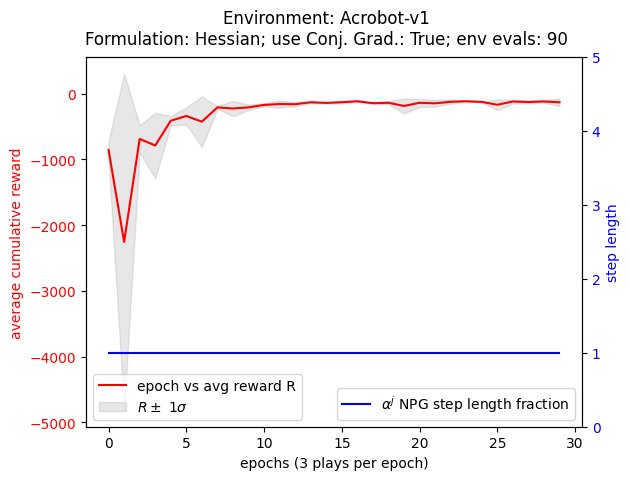

In [11]:
fig, ax1 = plt.subplots()
x = torch.arange(len(progress))
y1 = torch.tensor(progress)
y2 = torch.tensor(progress_std)
ax1.plot(x,y1, label='epoch vs avg reward R', c = 'r')    ;
ax1.fill_between(x, y1 - y2, y1 + y2, color='#888888', alpha=0.2, label='$R\pm$ 1$\sigma$')
ax1.set_xlabel(f'epochs ({eps_per_batch} plays per epoch)')
ax1.set_ylabel('average cumulative reward', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.plot(x,step_lengths, c = 'b', label=r'$\alpha^j$ NPG step length fraction')
ax2.set_ylim(0,5)

ax2.set_ylabel('step length', color='b') 
ax2.tick_params(axis='y', labelcolor='b')
ax1.legend()
ax2.legend(loc='lower right')
plt.suptitle(f"Environment: {env_params['id']}\nFormulation: {'Hessian' if not use_FIM else 'FIM'}; use Conj. Grad.: {use_CG }; env evals: {env_CP.env_iters}");
plt.savefig(os.path.join(base_path,case_name+'.png'))

## Play episode

In [78]:
n= 999
env = gym.make(**env_params, render_mode="human")
try:
    observation, info = env.reset(seed=82)
    observation = torch.tensor(observation, device=device)
    for _ in tqdm(range(n)):
        action = env_CP_policy.get_action(observation)
        observation,reward, terminated, _, info = env.step(action)#.cpu().numpy())
        observation = torch.tensor(observation, device=device)
        #print("info : ",info);
        
        if terminated :
            observation, info = env.reset()
            break
    env.close()
except: 
    env.close()


 49%|████▉     | 488/999 [00:16<00:17, 29.76it/s]


In [ ]:
env_CP_policy.mlp.log_std.exp()

tensor([1.4139], device='cuda:0', grad_fn=<ExpBackward0>)

## Plot value function (if possible)

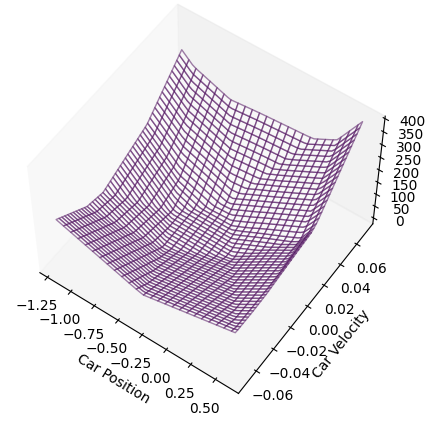

In [ ]:
import numpy as np
with torch.no_grad():   
  num_div = 50
  if env_params['id'] == 'Pendulum-v1':
    x = np.linspace(-np.pi,np.pi, num_div)
    x1 = np.cos(x); x2 = np.sin(x)
    y = np.linspace(-8,8, num_div)
    def out(i,j):
      return env_CP_value(torch.as_tensor([x1[i],x2[i],y[j]],**env_CP_policy.tensor_params)).item()
    lab1, lab2 = 'Angle', 'Angular Velocity'
    x = np.rad2deg(x)
  else:
    def out(i,j):
      return env_CP_value(torch.as_tensor([x[i],y[j]],**env_CP_policy.tensor_params)).item()
    low                 = env_CP.env.observation_space.low
    high                = env_CP.env.observation_space.high
    minmax_x, minmax_y  = np.vstack((low,high)).T
    x = np.linspace(*minmax_x, num_div)
    y = np.linspace(*minmax_y, num_div)
    lab1, lab2 = 'Car Position', 'Car Velocity'

  z = np.zeros([len(x), len(y)])
  for i in range(len(x)):
    for j in range(len(y)):
      z[i,j] =  out(i,j)
      
  fig = plt.figure(figsize=(10,5))
  ax = fig.add_subplot(1, 1, 1, projection='3d')
  X, Y = np.meshgrid(x, y)
  surf = ax.plot_surface(X, Y, z.T, rstride=1, cstride=2, shade=False, cmap=None, linewidth=1, label='Approximation', alpha=0.5)
  surf.set_edgecolors(surf.to_rgba(surf._A))
  surf.set_facecolors("white")
  ax.view_init(elev=55., azim=-55)
  #ax.scatter(*x_train.T.cpu(), y_train.cpu(), alpha = 0.5, color = 'r', s = 1)
  ax.grid(False)
  ax.set_xlabel(lab1)
  ax.set_ylabel(lab2);
#plt.savefig(os.path.join(base_path,case_name+'_V.png'))  